In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas_datareader.data as web
import FinanceDataReader as fdr
from sklearn import neighbors,svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import FinanceDataReader as fdr
import mglearn
from sklearn.preprocessing import MinMaxScaler
import sklearn

#성과 평가
from sklearn.metrics import confusion_matrix #오차행렬
from sklearn.metrics import accuracy_score #정확도
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve

setlen=2000

#분류모델
from sklearn.ensemble import GradientBoostingClassifier

C:\Users\이승희\AppData\Roaming\Python\Python36\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
C:\Users\이승희\AppData\Roaming\Python\Python36\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


[]

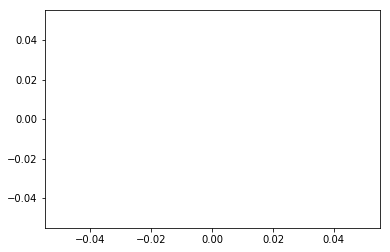

In [2]:
plt.plot()

In [5]:
KS=fdr.DataReader("KQ11","2009-01-01","2019-08-14")
KS.head()

Close    Open    High     Low    Volume  Change
Date                                                        
2009-01-02  339.76  337.38  339.77  335.86  399490.0  0.0232
2009-01-05  342.77  344.69  345.19  342.57  589410.0  0.0089
2009-01-06  348.41  345.74  350.76  345.73  671270.0  0.0165
2009-01-07  356.13  352.07  356.30  351.88  641700.0  0.0222
2009-01-08  356.52  352.58  357.58  351.69  573190.0  0.0011

In [8]:
#특성 추가 ------------------------------------------
    #이동평균선
def get_MA(df):
    MA_10=df["Close"].rolling(10).mean()
    MA_60=df["Close"].rolling(60).mean()
    df=df.assign(MA_10=MA_10,MA_60=MA_60).dropna()
    
    return df

    
    #스토캐스틱
def get_stochastic(df, n=15, m=5, t=3):
    # n일중 최고가
    ndays_high = df.High.rolling(window=n, min_periods=1).max()
    # n일중 최저가
    ndays_low = df.Low.rolling(window=n, min_periods=1).min()
 
    # Fast%K 계산
    kdj_k = ((df.Close - ndays_low) / (ndays_high - ndays_low))*100
    # Fast%D (=Slow%K) 계산
    kdj_d = kdj_k.ewm(span=m).mean()
    # Slow%D 계산
    kdj_j = kdj_d.ewm(span=t).mean()
 
    # dataframe에 컬럼 추가
    df = df.assign(kdj_k=kdj_k, kdj_d=kdj_d, kdj_j=kdj_j).dropna()
    
    return df

In [9]:
#이중 분류
KS=fdr.DataReader("SSEC","2009-01-01","2019-08-14")
time=np.linspace(0,10,len(KS),endpoint=False).reshape(-1,1)

#특성 추가---
KS=get_MA(KS)
KS=get_stochastic(KS)
X=KS
#--------


# 이중 분류, 미래 예측을 위한 시간조정 ------------------- 

y=pd.DataFrame(np.where(X.Change>=0,1,0),index=X.index).shift(-1).dropna()
X=X.loc[y.index]
#----------------------------


#--- 스케일 조정
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

StandardScaler = StandardScaler().fit(X) 
X_scaler= StandardScaler.transform(X)
X=pd.DataFrame(X_scaler,index=y.index,columns=X.columns)
X_train,X_test,y_train,y_test=X[:setlen],X[setlen:],y[:setlen],y[setlen:]
#- 차원 축소

#pca=PCA(n_components=2)
#pca.fit(X_scaler)

#X=pd.DataFrame(X_scaler,index=X.index,columns=KS.columns)
#X_pca=pca.transform(X_scaler)
#X_train,X_test,y_train,y_test=X_pca[:setlen],X_pca[setlen:],y[:setlen],y[setlen:]

array([[-2.24968486,  1.09494084],
       [-2.00833694, -0.43360963],
       [-2.51129268,  1.92672371],
       ...,
       [-0.47141662,  2.14086379],
       [-0.38218835,  1.41160028],
       [-0.43891029,  1.81861624]])

In [150]:
reg=neighbors.KNeighborsClassifier(n_neighbors=2).fit(X_train,y_train)
print("훈련 세트 정확도:{:.3f}".format(reg.score(X_train,y_train)))
print("테스트 세트 정확도:{:.3f}".format(reg.score(X_test,y_test)))

confusion=confusion_matrix(y_test,reg.predict(X_test))
print(confusion)

훈련 세트 정확도:0.772
테스트 세트 정확도:0.463
[[247  20]
 [285  16]]


C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  """Entry point for launching an IPython kernel.


In [151]:
reg=RandomForestClassifier(n_estimators=50).fit(X_train,y_train)
print("훈련 세트 정확도:{:.3f}".format(reg.score(X_train,y_train)))
print("테스트 세트 정확도:{:.3f}".format(reg.score(X_test,y_test)))

confusion=confusion_matrix(y_test,reg.predict(X_test))
print(confusion)

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


훈련 세트 정확도:1.000
테스트 세트 정확도:0.504
[[223  44]
 [238  63]]


In [152]:
reg=svm.SVC(C=1000,gamma=0.01).fit(X_train,y_train)
print("훈련 세트 정확도:{:.3f}".format(reg.score(X_train,y_train)))
print("테스트 세트 정확도:{:.3f}".format(reg.score(X_test,y_test)))

confusion=confusion_matrix(y_test,reg.predict(X_test))
print(confusion)

C:\Users\이승희\AppData\Roaming\Python\Python36\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


훈련 세트 정확도:0.536
테스트 세트 정확도:0.472
[[254  13]
 [287  14]]


In [153]:
reg=GradientBoostingClassifier(random_state=0).fit(X_train,y_train)
print("훈련 세트 정확도:{:.3f}".format(reg.score(X_train,y_train)))
print("테스트 세트 정확도:{:.3f}".format(reg.score(X_test,y_test)))

confusion=confusion_matrix(y_test,reg.predict(X_test))
print(confusion)

훈련 세트 정확도:0.695
테스트 세트 정확도:0.491
[[248  19]
 [270  31]]


C:\Users\이승희\AppData\Roaming\Python\Python36\site-packages\sklearn\ensemble\gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [12]:
# 다중 분류(개수가 많으면 안되는 것 같음)
#외삽 풀리는 KS11(코스피) KQ11(코스닥) SSEC(상해) HSCE(홍콩) RTSI(러시아)


#다중 20개

KS=fdr.DataReader("SSEC","2009-01-01","2019-08-14")
time=np.linspace(0,10,len(KS),endpoint=False).reshape(-1,1)

#특성 추가---
KS=get_MA(KS)
KS=get_stochastic(KS)
X=KS
#--------

# 20중 분류를 위한 종가 스케일 조정 ---------------
X_Close=X["Close"].values.reshape(-1,1)
minMaxScaler = MinMaxScaler().fit(X_Close)
X_trans= minMaxScaler.transform(X_Close) 
value=0.05
list=[]
for a in X_trans:
    for b in range(1,22):
        if a<=value:
            list.append(round(value,2))
            value=0.05
            break
        else:
            value=0.05*(b+1)    
            
y=list
#-----------------------------------------


#미래 예측을 위한 시간조정 ------------------- 
y=pd.DataFrame(np.array(y)*20,index=KS.index).shift(-1).dropna()
X=X.loc[y.index]
#----------------------------



#--- 스케일 조정
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

StandardScaler = MinMaxScaler().fit(X) 
X_scaler= StandardScaler.transform(X)
X=pd.DataFrame(X_scaler,index=y.index,columns=X.columns)
#- 차원 축소

#pca=PCA(n_components=2)
#pca.fit(X_scaler)

#X=pd.DataFrame(X_scaler,index=X.index,columns=KS.columns)
#X_pca=pca.transform(X_scaler)
#X_train,X_test,y_train,y_test=X_pca[:setlen],X_pca[setlen:],y[:setlen],y[setlen:]
#-----------------------
X_train,X_test,y_train,y_test=X[:setlen],X[setlen:],y[:setlen],y[setlen:]

In [286]:
# 다중 분류 10개


KS=fdr.DataReader("SSEC","2009-01-01","2019-08-14")
time=np.linspace(0,10,len(KS),endpoint=False).reshape(-1,1)

#특성 추가---
KS=get_MA(KS)
KS=get_stochastic(KS)
X=KS
#--------

# 10중 분류를 위한 종가 스케일 조정-------------------
X_Close=X["Close"].values.reshape(-1,1)
minMaxScaler = MinMaxScaler().fit(X_Close)
X_trans= minMaxScaler.transform(X_Close) 
y=pd.DataFrame(X_trans.round(1)*10,index=X.index)



#미래 예측을 위한 시간조정 -----------
y=y.shift(-1).dropna() 
X=X.loc[y.index]
#----------------------------


#--- 스케일 조정
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

StandardScaler = MinMaxScaler().fit(X) 
X_scaler= StandardScaler.transform(X)
X=pd.DataFrame(X_scaler,index=y.index,columns=X.columns)
#- 차원 축소

#pca=PCA(n_components=2)
#pca.fit(X_scaler)

#X=pd.DataFrame(X_scaler,index=X.index,columns=KS.columns)
#X_pca=pca.transform(X_scaler)
#X_train,X_test,y_train,y_test=X_pca[:setlen],X_pca[setlen:],y[:setlen],y[setlen:]
#-----------------------
X_train,X_test,y_train,y_test=X[:setlen],X[setlen:],y[:setlen],y[setlen:]



In [287]:
reg=neighbors.KNeighborsClassifier(n_neighbors=2).fit(X_train,y_train)
plt.plot(X.index,y,'go')
plt.plot(X[:setlen].index,reg.predict(X_train),'b.')
plt.plot(X[setlen:].index,reg.predict(X_test),'y.')
print("훈련 세트 정확도:{:.3f}".format(reg.score(X_train,y_train)))
print("테스트 세트 정확도:{:.3f}".format(reg.score(X_test,y_test)))
print("이웃-2")

confusion=confusion_matrix(y_test,reg.predict(X_test))
print(confusion)

훈련 세트 정확도:0.911
테스트 세트 정확도:0.803
이웃-2
[[  0   0   0   0   0]
 [ 11  97  10   0   0]
 [  0  16 125   8   0]
 [  0   0  22 192   9]
 [  0   0   0  27   6]]


C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  """Entry point for launching an IPython kernel.


In [280]:
reg=RandomForestClassifier(n_estimators=50).fit(X_train,y_train)
plt.plot(X.index,y,'go')
plt.plot(X[:setlen].index,reg.predict(X_train),'b.')
plt.plot(X[setlen:].index,reg.predict(X_test),'y.')
print("훈련 세트 정확도:{:.3f}".format(reg.score(X_train,y_train)))
print("테스트 세트 정확도:{:.3f}".format(reg.score(X_test,y_test)))
print("랜덤 포레스트")

confusion=confusion_matrix(y_test,reg.predict(X_test))
print(confusion)

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


훈련 세트 정확도:0.999
테스트 세트 정확도:0.732
랜덤 포레스트
[[29 11  0  0  0  0  0  0]
 [ 8 62  8  0  0  0  0  0]
 [ 0  8 60 17  1  0  0  0]
 [ 0  0 11 40 12  0  0  0]
 [ 0  0  0  8 77  3  0  0]
 [ 0  0  0  0 32 98  5  0]
 [ 0  0  0  0  0 11 16  5]
 [ 0  0  0  0  0  0  0  1]]


In [281]:
reg=svm.SVC(C=1000,gamma=0.001).fit(X_train,y_train)
plt.plot(X.index,y,'go')
plt.plot(X[:setlen].index,reg.predict(X_train),'b')
plt.plot(X[setlen:].index,reg.predict(X_test),'y')
print("훈련 세트 정확도:{:.3f}".format(reg.score(X_train,y_train)))
print("테스트 세트 정확도:{:.3f}".format(reg.score(X_test,y_test)))
print("SVM")

confusion=confusion_matrix(y_test,reg.predict(X_test))
print(confusion)

C:\Users\이승희\AppData\Roaming\Python\Python36\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


훈련 세트 정확도:0.805
테스트 세트 정확도:0.660
SVM
[[ 0  0  0  0  0  0  0  0  0]
 [ 2 22 16  0  0  0  0  0  0]
 [ 0  5 61 12  0  0  0  0  0]
 [ 0  0  4 63 18  1  0  0  0]
 [ 0  0  0 12 38 13  0  0  0]
 [ 0  0  0  0  5 81  2  0  0]
 [ 0  0  0  0  0 56 79  0  0]
 [ 0  0  0  0  0  0 25  0  7]
 [ 0  0  0  0  0  0  0  0  1]]


C:\Users\이승희\AppData\Roaming\Python\Python36\site-packages\sklearn\ensemble\gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


훈련 세트 정확도:1.000
테스트 세트 정확도:0.721
그레이디언트 부스팅
[[ 30  10   0   0   0   0   0   0]
 [ 13  54  11   0   0   0   0   0]
 [  0   6  62  17   1   0   0   0]
 [  0   0  13  39  11   0   0   0]
 [  0   0   0   9  66  13   0   0]
 [  0   0   0   0  11 108  16   0]
 [  0   0   0   0   0   8  17   7]
 [  0   0   0   0   0   0   0   1]]


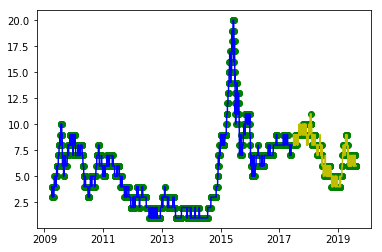

In [282]:
from sklearn.ensemble import GradientBoostingClassifier
reg=GradientBoostingClassifier(random_state=0).fit(X_train,y_train)
plt.plot(X.index,y,'go')
plt.plot(X[:setlen].index,reg.predict(X_train),'b')
plt.plot(X[setlen:].index,reg.predict(X_test),'y')
print("훈련 세트 정확도:{:.3f}".format(reg.score(X_train,y_train)))
print("테스트 세트 정확도:{:.3f}".format(reg.score(X_test,y_test)))
print("그레이디언트 부스팅")

confusion=confusion_matrix(y_test,reg.predict(X_test))
print(confusion)

In [269]:
reg=LogisticRegression().fit(X_train,y_train)
plt.plot(X.index,y,'go')
plt.plot(X[:setlen].index,reg.predict(X_train),'b')
plt.plot(X[setlen:].index,reg.predict(X_test),'y')
print("훈련 세트 정확도:{:.3f}".format(reg.score(X_train,y_train)))
print("테스트 세트 정확도:{:.3f}".format(reg.score(X_test,y_test)))
print("SVM")

confusion=confusion_matrix(y_test,reg.predict(X_test))
print(confusion)

훈련 세트 정확도:0.371
테스트 세트 정확도:0.037
SVM
[[ 8  0  0  0  0  0  0  0  0  0]
 [ 7 10  0  0  0  0  0  0  0  0]
 [ 6 76  3  0  0  0  0  0  0  0]
 [ 0 32 27  0  0  0  0  0  0  0]
 [ 0  2 53  0  0  0  0  0  0  0]
 [ 0  0 70  0  0  0  0  0  0  0]
 [ 0  0 77  0  0  0  0  0  0  0]
 [ 0  0 65 20  0  0  0  0  0  0]
 [ 0  0 38 51  0  0  0  0  0  0]
 [ 0  0  0 23  0  0  0  0  0  0]]


C:\Users\이승희\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\이승희\AppData\Roaming\Python\Python36\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\이승희\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [203]:
#그리드서치 간단모듈
from sklearn.model_selection import GridSearchCV

param_grid={'random_state':[2,4,8,16,32,64]}
grid_search=GridSearchCV(GradientBoostingClassifier(),param_grid,cv=5,return_train_score=True)
grid_search.fit(X_train,y_train)
grid_search.best_estimator_


C:\Users\이승희\AppData\Roaming\Python\Python36\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\이승희\AppData\Roaming\Python\Python36\site-packages\sklearn\ensemble\gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\이승희\AppData\Roaming\Python\Python36\site-packages\sklearn\ensemble\gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\이승희\AppData\Roaming\Python\Python36\site-packages\sklearn\ensemble\gradient_boosting.py:1450: DataConversionWarni

C:\Users\이승희\AppData\Roaming\Python\Python36\site-packages\sklearn\ensemble\gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\이승희\AppData\Roaming\Python\Python36\site-packages\sklearn\ensemble\gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\이승희\AppData\Roaming\Python\Python36\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\이승희\AppData\Roaming\Python\Python36\site-packages\sklearn\ensemble\gradient_boosting.py:1

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=4, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [205]:
#히트맵
results=pd.DataFrame(grid_search.cv_results_)
scores=np.array(results.mean_test_score).reshape(6,1)
mglearn.tools.heatmap(scores,xlabel='length',xticklabels='',ylabel='random_state',yticklabels=param_grid['random_state'])

In [206]:
#그리드서치 간단모듈
from sklearn.model_selection import GridSearchCV

param_grid={'n_estimators':[10,50,100,120,300]}
grid_search=GridSearchCV(RandomForestClassifier(),param_grid,cv=5,return_train_score=True)
grid_search.fit(X_train,y_train)
grid_search.best_estimator_
#히트맵
results=pd.DataFrame(grid_search.cv_results_)
scores=np.array(results.mean_test_score).reshape(5,1)
mglearn.tools.heatmap(scores,xlabel='length',xticklabels='',ylabel='n_estimators',yticklabels=param_grid['n_estimators'])


C:\Users\이승희\AppData\Roaming\Python\Python36\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\이승희\AppData\Roaming\Python\Python36\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\이승희\AppData\Roaming\Python\Python36\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\이승희\AppData\Roaming\Python\Python36\site-packages\sklearn\model_selection\_validation

In [336]:

reg1=neighbors.KNeighborsClassifier(n_neighbors=2).fit(X_train,y_train).predict(X_test)
reg2=svm.SVC(C=1000,gamma=0.01).fit(X_train,y_train).predict(X_test)
reg3=RandomForestClassifier(n_estimators=50).fit(X_train,y_train).predict(X_test)
reg4=GradientBoostingClassifier(random_state=0).fit(X_train,y_train).predict(X_test)

print("최근접 이웃 모델의 f1 score : {:.2f}".format(f1_score(y_test,reg1)))
print("SVM 모델의 f1 score : {:.2f}".format(f1_score(y_test,reg2)))
print("랜덤 포레스트 모델의 f1 score : {:.2f}".format(f1_score(y_test,reg3)))
print("그레이디언트 부스팅 모델의 f1 score : {:.2f}".format(f1_score(y_test,reg4)))

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  
C:\Users\이승희\AppData\Roaming\Python\Python36\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.
C:\Users\이승희\AppData\Roaming\Python\Python36\site-packages\sklearn\ensemble\gradient_boosting.py:1450: DataConversionWarning: A column-vector y w

최근접 이웃 모델의 f1 score : 0.37
SVM 모델의 f1 score : 0.67
랜덤 포레스트 모델의 f1 score : 0.63
그레이디언트 부스팅 모델의 f1 score : 0.66


In [323]:
print("이중 분류")
print(classification_report(y_test,reg4,target_names=["하락(0)","상승(1)"]))

이중 분류
              precision    recall  f1-score   support

       하락(0)       0.48      0.37      0.42       255
       상승(1)       0.51      0.63      0.56       268

    accuracy                           0.50       523
   macro avg       0.50      0.50      0.49       523
weighted avg       0.50      0.50      0.49       523



In [290]:
print("10중 분류")
print(classification_report(y_test,reg1))

10중 분류
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00         0
         2.0       0.86      0.82      0.84       118
         3.0       0.80      0.84      0.82       149
         4.0       0.85      0.86      0.85       223
         5.0       0.40      0.18      0.25        33

    accuracy                           0.80       523
   macro avg       0.58      0.54      0.55       523
weighted avg       0.81      0.80      0.80       523



C:\Users\이승희\AppData\Roaming\Python\Python36\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [333]:
X_trainval,X_test,y_trainval,y_test=X[:setlen],X[setlen:],y[:setlen],y[setlen:]
X_train,X_val,y_train,y_val=X[:1500],X[1500:],y[:1500],y[1500:]

reg=GradientBoostingClassifier(random_state=0).fit(X_train,y_train)
y_pred_lower_threshold=reg.decision_function(X_test)>-.8
print(classification_report(y_test,y_pred_lower_threshold,target_names=["하락(0)","상승(1)"]))


              precision    recall  f1-score   support

       하락(0)       0.60      0.01      0.02       255
       상승(1)       0.51      0.99      0.68       268

    accuracy                           0.51       523
   macro avg       0.56      0.50      0.35       523
weighted avg       0.56      0.51      0.36       523



C:\Users\이승희\AppData\Roaming\Python\Python36\site-packages\sklearn\ensemble\gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [343]:

reg1=neighbors.KNeighborsClassifier(n_neighbors=2).fit(X_train,y_train)
reg2=svm.SVC(C=1000,gamma=0.01).fit(X_train,y_train)
reg3=RandomForestClassifier(n_estimators=50).fit(X_train,y_train)
reg4=GradientBoostingClassifier(random_state=0).fit(X_train,y_train)

precision,recall,thresholds=precision_recall_curve(y_test,reg4.decision_function(X_test))

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  
C:\Users\이승희\AppData\Roaming\Python\Python36\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.
C:\Users\이승희\AppData\Roaming\Python\Python36\site-packages\sklearn\ensemble\gradient_boosting.py:1450: DataConversionWarning: A column-vector y w

In [14]:

reg1=neighbors.KNeighborsClassifier(n_neighbors=2).fit(X_train,y_train)
reg2=svm.SVC(C=1000,gamma=0.01).fit(X_train,y_train)
reg3=RandomForestClassifier(n_estimators=50).fit(X_train,y_train)
reg4=GradientBoostingClassifier(random_state=0).fit(X_train,y_train)

precision,recall,thresholds=precision_recall_curve(y_test,reg3.decision_function(X_test))

close_zero=np.argmin(np.abs(thresholds))
plt.plot(precision[close_zero],recall[close_zero],'o',markersize=10,label='0',fillstyle="none",c='k',mew=2)
plt.plot(precision,recall,label="curve")
plt.xlabel("precision")
plt.ylabel('recall')
plt.legend(loc="best")


C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  
C:\Users\이승희\AppData\Roaming\Python\Python36\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.
C:\Users\이승희\AppData\Roaming\Python\Python36\site-packages\sklearn\ensemble\gradient_boosting.py:1450: DataConversionWarning: A column-vector y w

AttributeError: 'RandomForestClassifier' object has no attribute 'decision_function'

In [15]:

# predict_proba
plt.figure(figsize=(12, 12))

precision_rf,recall_rf,thresholds_rf=precision_recall_curve(y_test,reg3.predict_proba(X_test)[:,1])
plt.plot(precision_rf,recall_rf,label="rf")
close_default_rf=np.argmin(np.abs(thresholds_rf-0.5))
plt.plot(precision_rf[close_default_rf],recall_rf[close_default_rf],'^',c='k',markersize=10,label="rf : threshold 0.5",fillstyle="none",mew=2)
plt.xlabel("precision")
plt.ylabel("recall")
plt.legend(loc="best")

precision_svm,recall_svm,thresholds_svm=precision_recall_curve(y_test,reg2.decision_function(X_test))
plt.plot(precision_svm[close_zero],recall_svm[close_zero],'o',markersize=10,label=' svc :threshold 0',fillstyle="none",mew=2)
plt.plot(precision_svm,recall_svm,label="GB")
plt.legend(loc="best")

precision,recall,thresholds=precision_recall_curve(y_test,reg.decision_function(X_test))
plt.plot(precision[close_zero],recall[close_zero],'o',markersize=10,label=' GB :threshold 0',fillstyle="none",c='k',mew=2)
plt.plot(precision,recall,label="GB")
plt.legend(loc="best")


ValueError: multiclass format is not supported

<Figure size 864x864 with 0 Axes>

In [16]:
from sklearn.metrics import average_precision_score
ap_rf=average_precision_score(y_test,reg3.predict_proba(X_test)[:,1])
ap_svc=average_precision_score(y_test,reg2.decision_function(X_test))
ap_GB=average_precision_score(y_test,reg4.decision_function(X_test))
print("랜덤 포레스트의 평균 정밀도 : {:.3f}".format(ap_rf))
print("SVM의 평균 정밀도 : {:.3f}".format(ap_svc))
print("그레이디언트 부스팅의 평균 정밀도 : {:.3f}".format(ap_GB))

ValueError: multiclass format is not supported

In [391]:
from sklearn.metrics import roc_curve

plt.figure(figsize=(12, 12))
fpr_rf,tpr_rf,thresholds_rf=roc_curve(y_test,reg3.predict_proba(X_test)[:,1])
fpr_svc,tpr_svc,thresholds_svc=roc_curve(y_test,reg2.decision_function(X_test))
fpr_GB,tpr_GB,thresholds_GB=roc_curve(y_test,reg4.decision_function(X_test))
close_default_rf=np.argmin(np.abs(thresholds_rf - 0.5))

plt.plot(fpr_rf,tpr_rf,'k')
plt.plot(fpr_svc,tpr_svc,'b')
plt.plot(fpr_GB,tpr_GB,'yellow')
plt.xlabel("FPR")
plt.ylabel("TPR(recall)")

plt.plot(fpr_svc[close_zero],tpr_svc[close_zero],'o',markersize=10,label="SVC recall : 0 ",fillstyle="none",mew=2)
plt.plot(fpr_rf[close_default_rf],tpr_rf[close_default_rf],'^',markersize=10,label="RF recall : 0.5",fillstyle="none",mew=2)
plt.plot(fpr_GB[close_zero],tpr_GB[close_zero],'^',markersize=10,label="GB",fillstyle="none",mew=2)

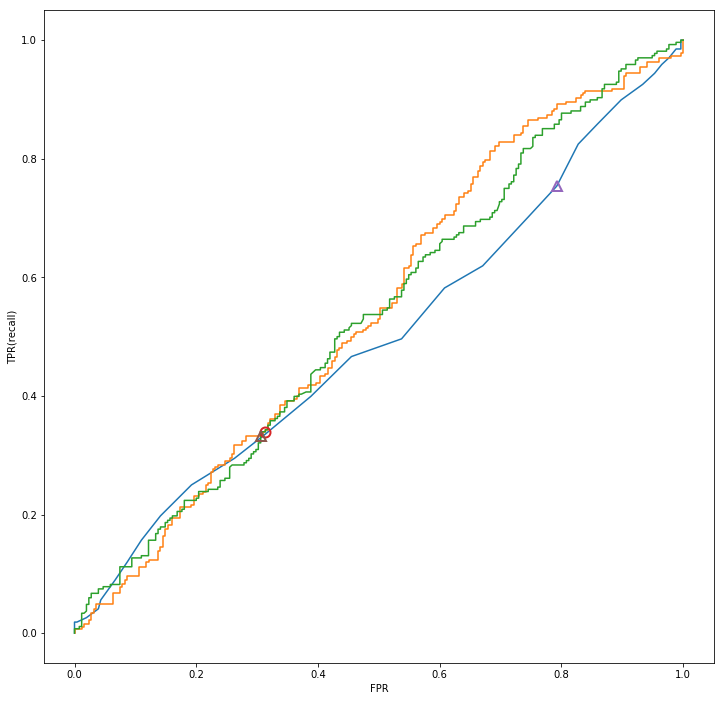

In [394]:
from sklearn.metrics import roc_auc_score
rf_auc=roc_auc_score(y_test,reg3.predict_proba(X_test)[:,1])
svc_auc=roc_auc_score(y_test,reg2.decision_function(X_test))
GB_auc=roc_auc_score(y_test,reg4.decision_function(X_test))
print("랜덤 포레스트의 평균 정밀도 : {:.3f}".format(rf_auc))
print("SVM의 평균 정밀도 : {:.3f}".format(svc_auc))
print("그레이디언트 부스팅의 평균 정밀도 : {:.3f}".format(GB_auc))

랜덤 포레스트의 평균 정밀도 : 0.501
SVM의 평균 정밀도 : 0.547
그레이디언트 부스팅의 평균 정밀도 : 0.538
